# PS4E6 - Academic Success Classification 🎓

# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
import xgboost

from lightgbm import LGBMClassifier
import lightgbm

from catboost import CatBoostClassifier
import catboost

import optuna

In [3]:
train = pd.read_csv("./input/train.csv", index_col="id")
test = pd.read_csv("./input/test.csv", index_col="id")

# Data in a glance

📌 Original Dataset and Variables table available [here](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)
and data original paper [here](https://www.mdpi.com/2306-5729/7/11/146)

📌 This dataset doesn't have missing values!

In [4]:
train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

### Type transformtation and Label Encoding

📌 We'll encode our target with a LabelEncoder

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train.Target = label_encoder.fit_transform(train.Target)
train.Target.head()

id
0    2
1    0
2    0
3    1
4    2
Name: Target, dtype: int32

📌 Some of these columns are categorical, let's change the dtype.

In [7]:
categorical_columns = ["Marital status", "Application mode", "Course", "Daytime/evening attendance", 
                        "Previous qualification", "Nacionality", "Mother's qualification", "Father's qualification",
                        "Mother's occupation", "Father's occupation"]

bool_columns = ["Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", "Gender",
                "Scholarship holder", "International"]

train[categorical_columns] = train[categorical_columns].astype('category')
train["Target"] = train["Target"].astype('category')
train[bool_columns] = train[bool_columns].astype('bool')

test[categorical_columns] = test[categorical_columns].astype('category')
test[bool_columns] = test[bool_columns].astype('bool')

# We'll use this later
numeric_columns = train.select_dtypes('number').columns

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  76518 non-null  category
 1   Application mode                                76518 non-null  category
 2   Application order                               76518 non-null  int64   
 3   Course                                          76518 non-null  category
 4   Daytime/evening attendance                      76518 non-null  category
 5   Previous qualification                          76518 non-null  category
 6   Previous qualification (grade)                  76518 non-null  float64 
 7   Nacionality                                     76518 non-null  category
 8   Mother's qualification                          76518 non-null  category
 9   Father's qualification           

## Categorical Data

In [8]:
train.select_dtypes(include='category').head()

,Marital status,Application mode,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Target
id,,,,,,,,,,,
0,1,1,9238,1,1,1,1,19,5,5,2
1,1,17,9238,1,1,1,19,19,9,9,0
2,1,17,9254,1,1,1,3,19,2,3,0
3,1,1,9500,1,1,1,19,3,3,2,1
4,1,1,9500,1,1,1,19,37,4,9,2


In [9]:
train.select_dtypes(include='category').describe()

,Marital status,Application mode,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Target
count,76518,76518,76518,76518,76518,76518,76518,76518,76518,76518,76518
unique,6,22,19,2,21,18,35,39,40,56,3
top,1,1,9500,1,1,1,1,37,9,9,2
freq,70189,35227,12074,70038,67183,76013,20202,23290,32386,22320,36282


## Numerical Data

In [10]:
train.select_dtypes(include='number').head()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
id,,,,,,,,,,,,,,,,,,,
0,1,126.0,122.6,18,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02
1,1,125.0,119.8,18,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02
2,2,137.0,144.7,18,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92
3,3,131.0,126.1,18,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02
4,2,132.0,120.1,18,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32


In [11]:
train.select_dtypes(include='number').describe()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,1.644410,132.378766,125.363971,22.278653,0.188871,5.891516,7.352362,4.178520,9.995862,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,1.229645,10.995328,12.562328,6.889241,1.175296,1.671776,3.508292,2.687995,5.264224,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,0.000000,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,125.000000,118.000000,18.000000,0.000000,5.000000,6.000000,2.000000,10.666667,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,133.100000,124.600000,19.000000,0.000000,6.000000,7.000000,5.000000,12.166667,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,2.000000,140.000000,132.000000,23.000000,0.000000,6.000000,9.000000,6.000000,13.314286,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,9.000000,190.000000,190.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


## Boolean Data

In [12]:
train.select_dtypes(include='bool').head()

,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International
id,,,,,,,
0,False,False,False,True,False,True,False
1,True,False,False,True,False,False,False
2,False,False,False,True,True,False,False
3,True,False,False,True,False,True,False
4,True,False,False,True,False,False,False


In [13]:
train.select_dtypes(include='bool').describe()

,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International
count,76518,76518,76518,76518,76518,76518,76518
unique,2,2,2,2,2,2,2
top,True,False,False,True,False,False,False
freq,43559,76232,71056,68380,52352,57588,76011


# EDA

## Feature Distribution

### Numeric Features

Text(0, 0.5, '')

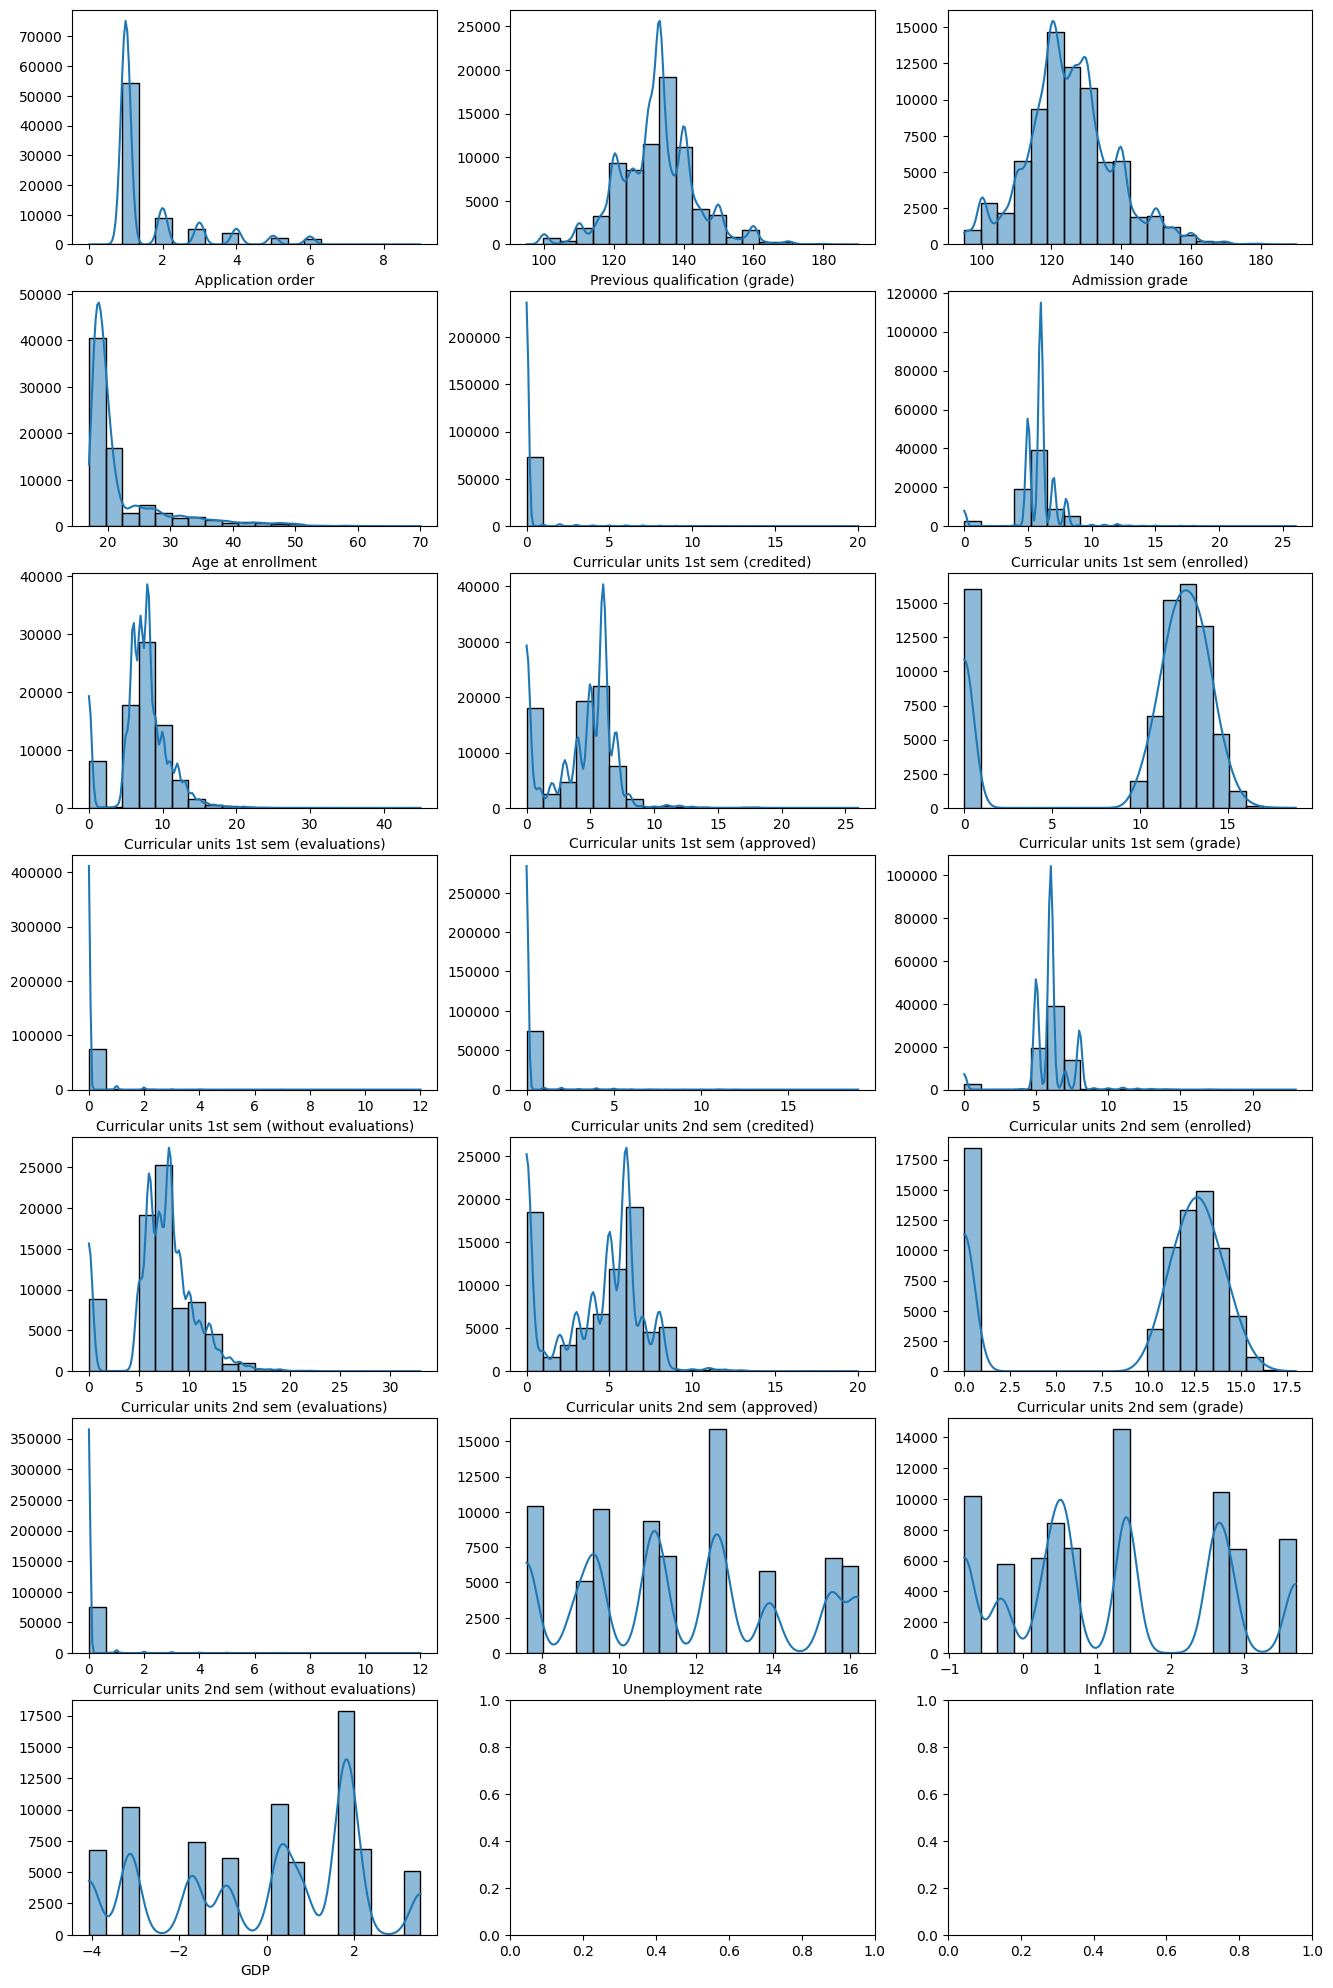

In [14]:
reshaped = np.reshape(numeric_columns[:-1], (6,3))

_, axs = plt.subplots(7, 3, figsize=(16, 25))

for i in range(6):
    for j in range(3):
        ax = sns.histplot(x=train[reshaped[i][j]], ax=axs[i][j], bins=20, kde=True)
        ax.set_ylabel(None)
        
ax = sns.histplot(x=train[numeric_columns[-1]], ax=axs[6][0], bins=20, kde=True)
ax.set_ylabel(None)

### Categorical Features

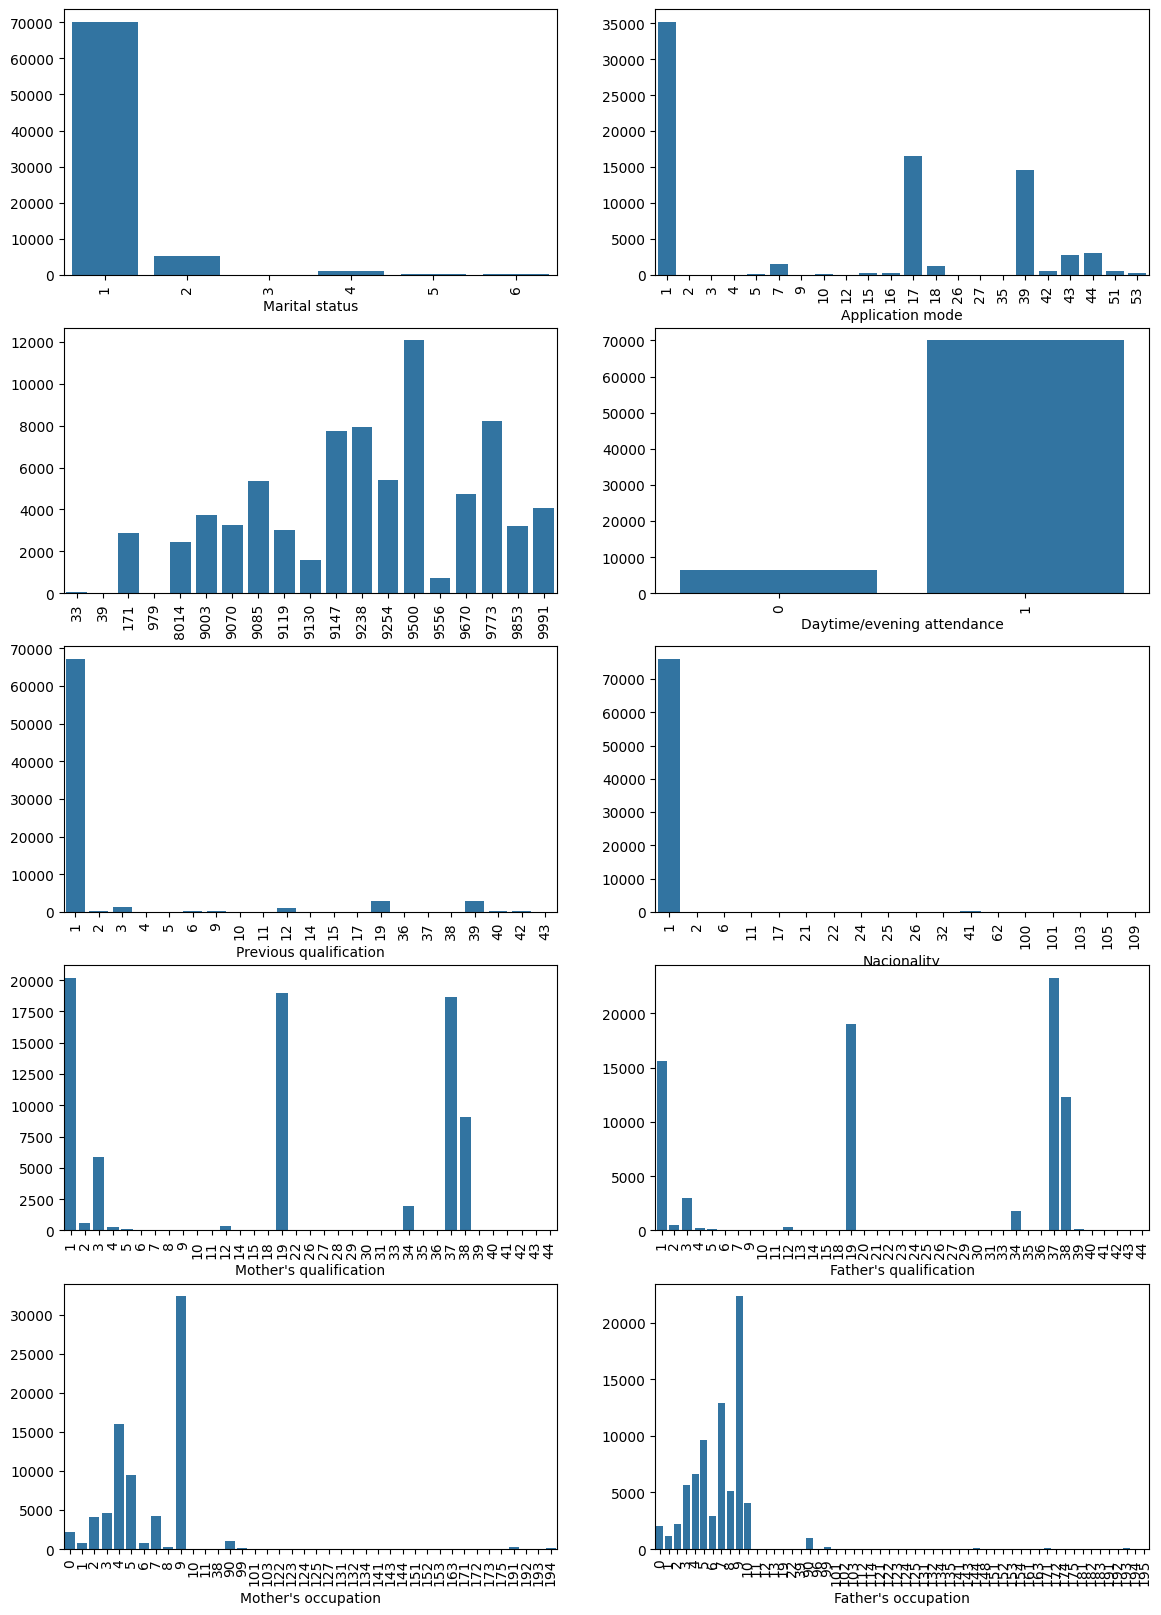

In [15]:
reshaped = np.reshape(categorical_columns, (5,2))

_, axs = plt.subplots(5, 2, figsize=(14, 20))

for i in range(5):
    for j in range(2):
        ax = sns.countplot(x=train[reshaped[i][j]], ax=axs[i][j])
        ax.set_ylabel(None)
        ax.tick_params(axis='x', rotation=90)

### Boolean Features

Text(0, 0.5, '')

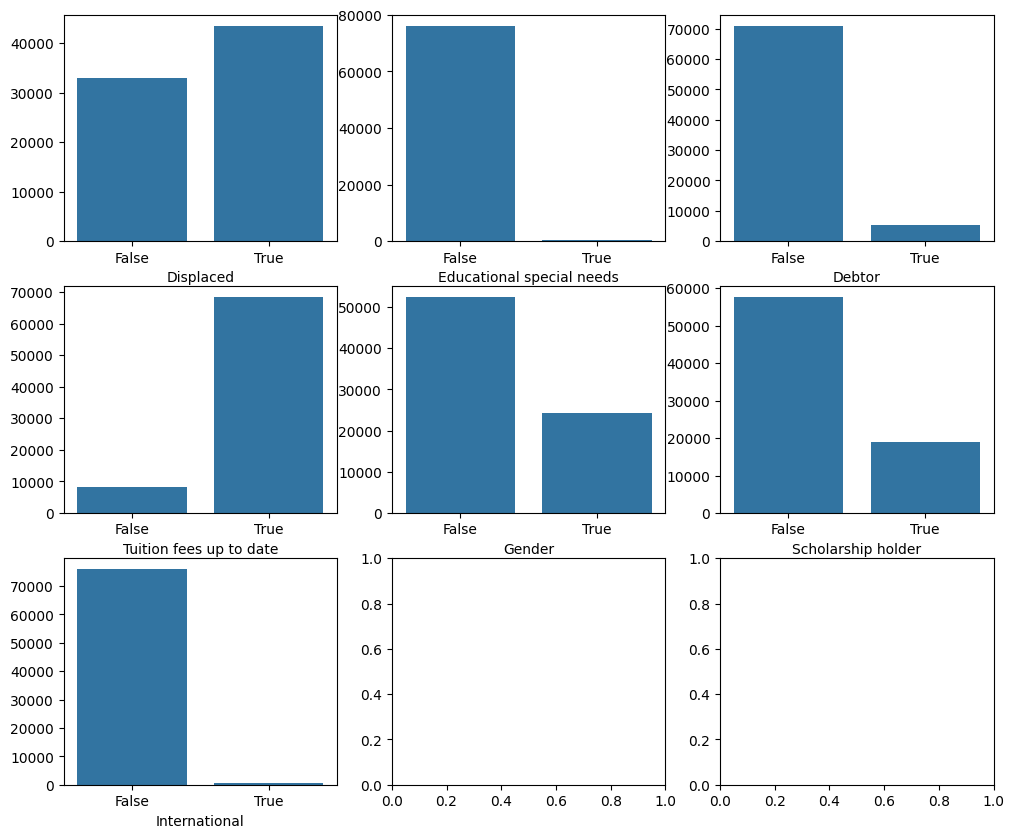

In [16]:
reshaped_bools = np.reshape(bool_columns[:-1], (2,3))

_, axs = plt.subplots(3, 3, figsize=(12, 10))

for i in range(2):
    for j in range(3):
        ax = sns.countplot(x=train[reshaped_bools[i][j]], ax=axs[i][j])
        ax.set_ylabel(None)
        
ax = sns.countplot(x=train[bool_columns[-1]], ax=axs[2][0])
ax.set_ylabel(None)

## Target Distribution

<Axes: xlabel='Target', ylabel='count'>

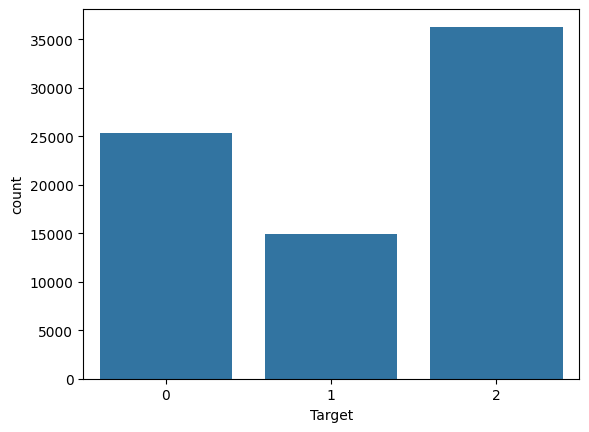

In [17]:
sns.countplot(x=train.Target)

## Mutual Information

In [18]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=42, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=True)
    return mi_scores

mi_scores = make_mi_scores(train.drop(columns="Target"), train["Target"])

<Axes: >

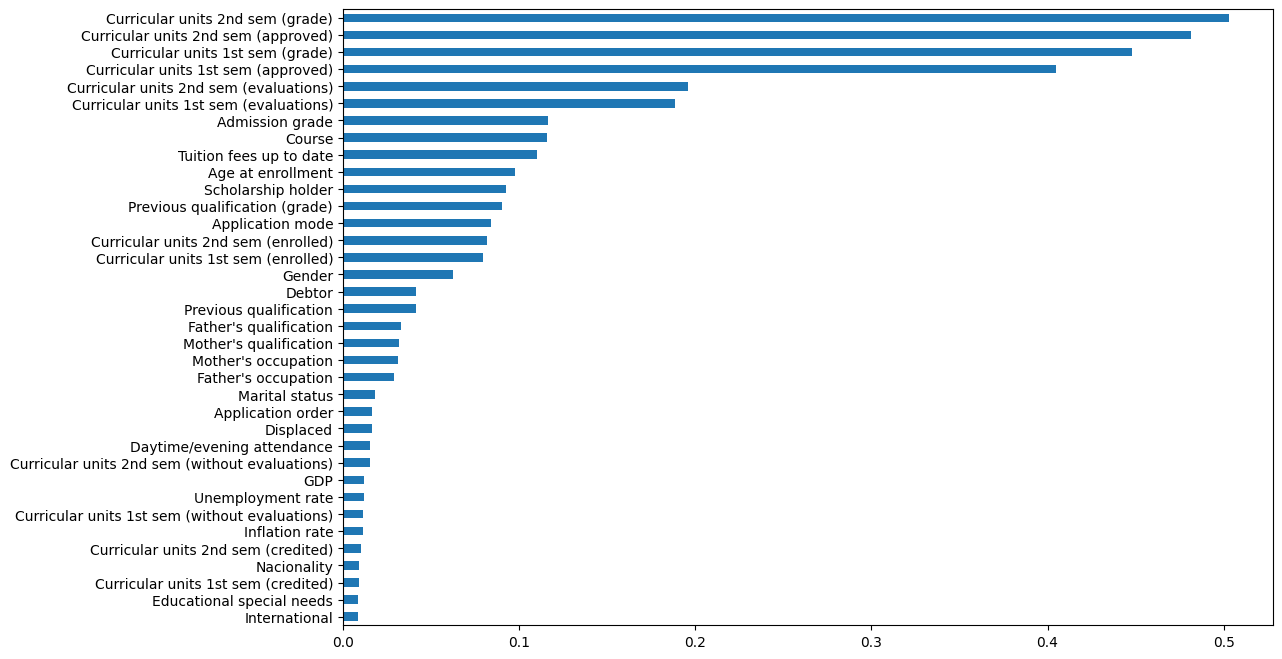

In [19]:
mi_scores.plot.barh(figsize=(12,8))

## Correlation

In [20]:
def plot_correlation(corr_matrix):
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    return sns.heatmap(corr_matrix, mask=mask, center=0)

<Axes: >

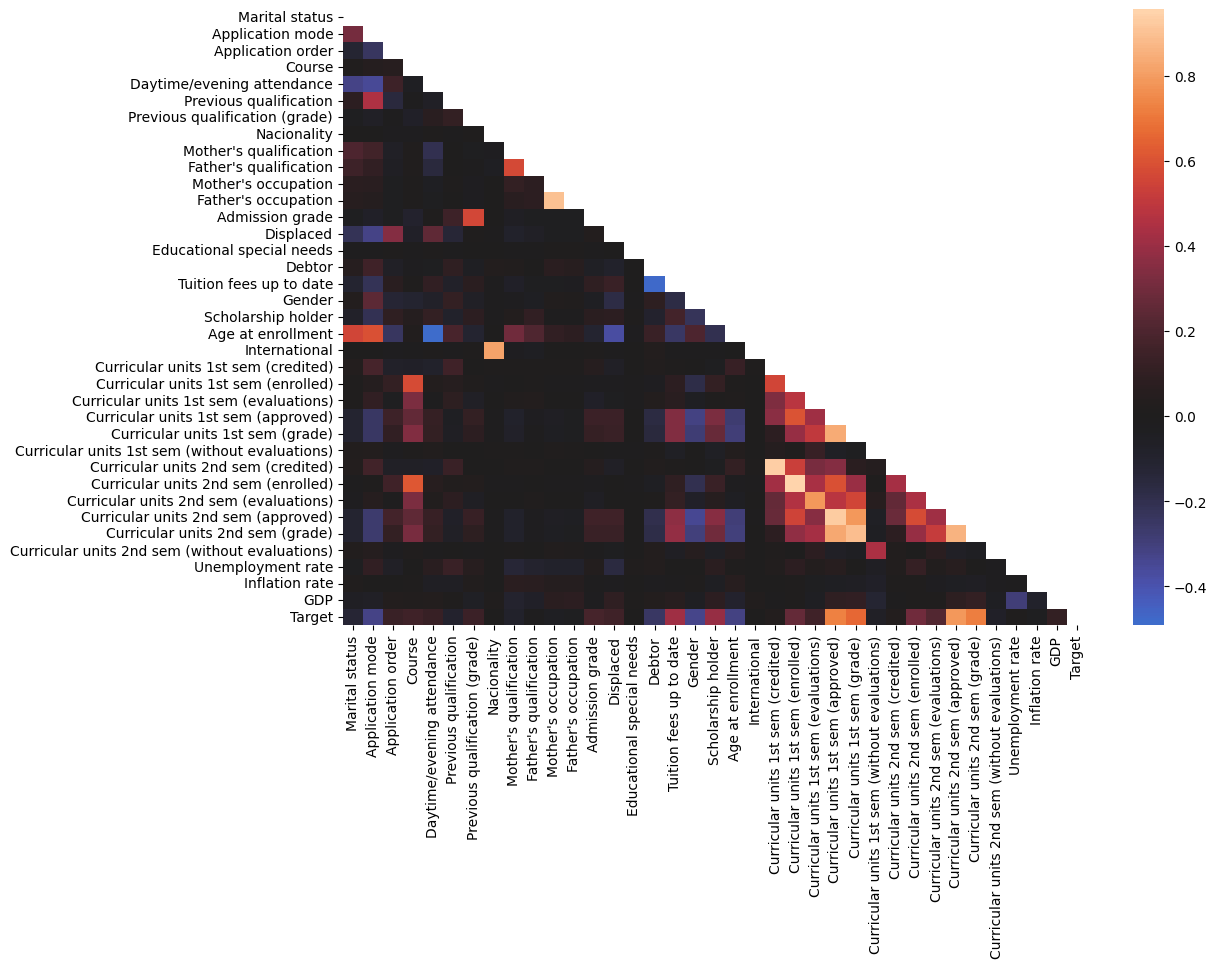

In [21]:
plot_correlation(train.corr())

## Feature Importance

In [22]:
fi_xgb = XGBClassifier(random_state=42, enable_categorical=True)
fi_xgb.fit(train.drop(columns='Target'), train.Target)

fi_lgbm = LGBMClassifier(random_state=42, verbose=0)
fi_lgbm.fit(train.drop(columns='Target'), train.Target)

fi_cat = CatBoostClassifier(random_state=42, verbose=0, cat_features=categorical_columns)
fi_cat.fit(train.drop(columns='Target'), train.Target)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [23]:
def catboost_importance(
    model: CatBoostClassifier, ax, ignore_zero=True, importance_type="auto", 
    height=0.2, values_format="{v}", figsize=None, title=None, grid=True
):
    
    importances = model.feature_importances_
    feature_names = model.feature_names_
    
    tuples = sorted(zip(feature_names, importances), key=lambda x: x[1])
    
    if ignore_zero:
        tuples = [x for x in tuples if x[1] > 0]
        
    labels, values = zip(*tuples)
    ylocs = np.arange(len(values))
    
    ax.barh(ylocs, values, align='center', height=height)

    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, values_format.format(v=x), va='center')

    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    
    ax.set_xlim((0, max(values) * 1.1))
    ax.set_ylim((-1, len(values)))

    if title is not None:
        ax.set_title(title)
    
    ax.grid(grid)
    
    return ax

<Axes: title={'center': 'CatBoost Feature Importance'}>

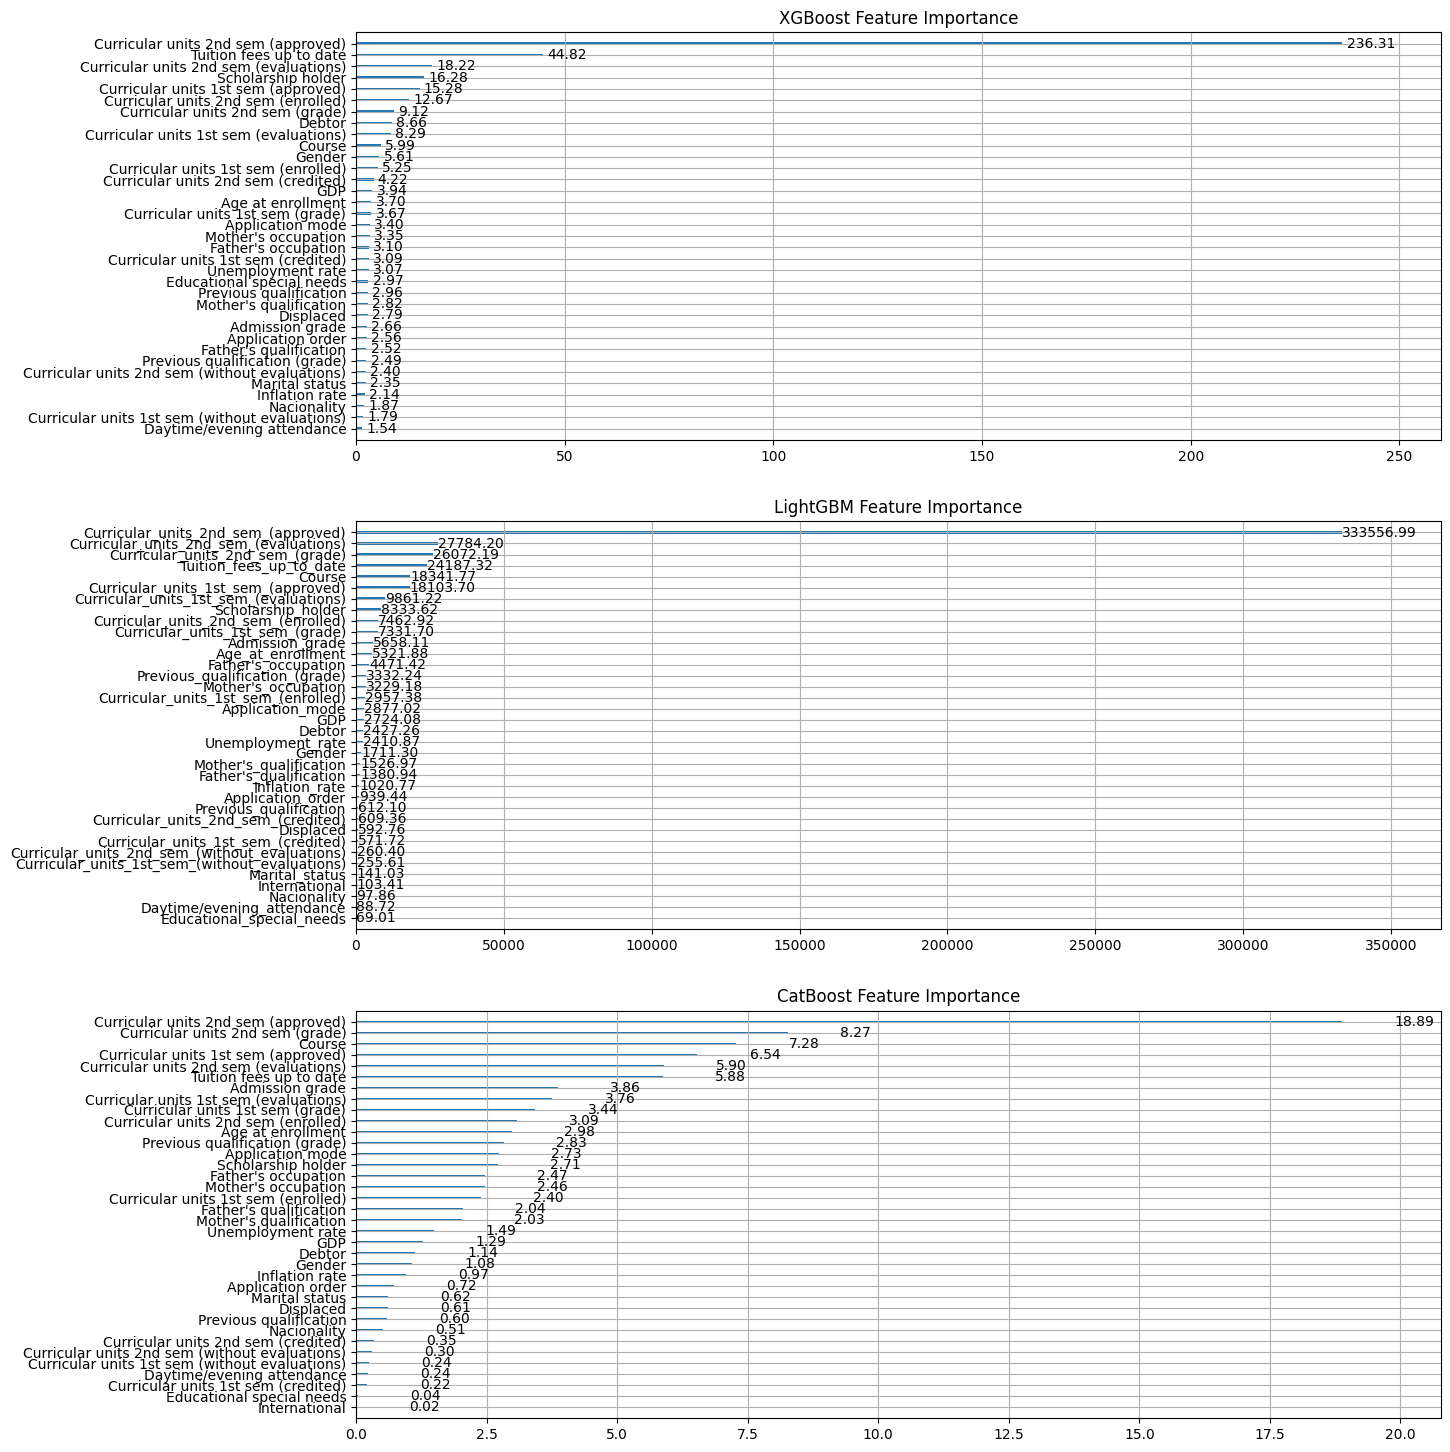

In [24]:
_, axs = plt.subplots(3, 1, figsize=(14, 18))

xgboost.plot_importance(fi_xgb, ax=axs[0], title="XGBoost Feature Importance", xlabel=None, ylabel=None, importance_type="gain", values_format="{v:.2f}")
lightgbm.plot_importance(fi_lgbm, ax=axs[1], title="LightGBM Feature Importance", xlabel=None, ylabel=None, importance_type="gain", precision=2)
catboost_importance(fi_cat, ax=axs[2], title="CatBoost Feature Importance", importance_type="auto", values_format="{v:.2f}")

# Model Evaluation

In [25]:
train_X = train.drop(columns='Target')
train_y = train.Target

## Optuna setup

📌 We'll tune and evaluate our models using Optuna

In [26]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial: optuna.Trial, X, y, float_params: dict, int_params: dict, model_type: str):
    params = {}

    for key, arg_list in float_params.items():
        param = trial.suggest_float(key, *arg_list)
        params[key] = param

    for key, arg_list in int_params.items():
        param = trial.suggest_int(key, *arg_list)
        params[key] = param

    if model_type == 'xgb':
        model = create_pipeline(XGBClassifier(**params, random_state=42, n_jobs=-1, enable_categorical=True,))
    elif model_type == 'lgbm':
        model = create_pipeline(LGBMClassifier(**params, random_state=42, n_jobs=-1, verbose=-1, seed=42, num_class=3))
    elif model_type == 'hgb':
        model = create_pipeline(HistGradientBoostingClassifier(**params, random_state=42, scoring="accuracy"))
    elif model_type == 'catboost':
        model = create_pipeline(CatBoostClassifier(**params, random_state=42, silent=True))
    elif model_type == 'rf':
        model = create_pipeline(RandomForestClassifier(**params, random_state=42, n_jobs=-1))
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
        
    return cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()

## XGBoost

In [27]:
float_params = {
    'learning_rate': [0.01, 0.5],
    'lambda': [7.0, 12.0],
    'alpha': [5.0, 13.0],
    'subsample': [0.1, 1.0]
}

int_params = {
    'max_depth': [3, 10],
    'n_estimators': [100, 500],
    'min_child_weight': [0, 10]
}

# xgb_study = optuna.create_study(direction="maximize")
# xgb_study.optimize(lambda trial: objective(trial, train_X, train_y, float_params, int_params, model_type='xgb'), n_trials=100)

In [28]:
# print("Best parameters:", xgb_study.best_params)

Best parameters: {'learning_rate': 0.212108403193391, 'lambda': 9.145657452524992, 'alpha': 11.655936623303198, 'subsample': 0.7684884954143946, 'max_depth': 3, 'n_estimators': 485, 'min_child_weight': 10}

In [29]:
# print("Best score:", xgb_study.best_value)

Best score: 0.8328105156138733

In [30]:
# optuna.visualization.plot_optimization_history(xgb_study)

In [31]:
# optuna.visualization.plot_slice(xgb_study, params=["alpha", "lambda", "learning_rate"])

In [32]:
# optuna.visualization.plot_slice(xgb_study, params=["max_depth", "n_estimators"])

In [33]:
# optuna.visualization.plot_param_importances(xgb_study)

## LGBM

In [34]:
float_params = {
    'learning_rate': [0.01, 0.5],
    'reg_lambda': [7.0, 12.0],
    'reg_alpha': [5.0, 13.0],
    'subsample': [0.1, 1.0]
}

int_params = {
    'max_depth': [3, 6],
    'n_estimators': [100, 550],
}

# lgbm_study = optuna.create_study(direction="maximize")
# lgbm_study.optimize(lambda trial: objective(trial, train_X, train_y, float_params, int_params, model_type='lgbm'), n_trials=100)

In [35]:
# print("Best parameters:", lgbm_study.best_params)

Best parameters: {'learning_rate': 0.4301610453567858, 'reg_lambda': 11.9885301860372, 'reg_alpha': 5.987382221711721, 'subsample': 0.8242826631788114, 'max_depth': 3, 'n_estimators': 153}

In [36]:
# print("Best score:", lgbm_study.best_value)

Best score: 0.8329673698111189

In [37]:
# optuna.visualization.plot_optimization_history(lgbm_study)

In [38]:
# optuna.visualization.plot_slice(lgbm_study, params=["reg_lambda", "learning_rate"])

In [39]:
# optuna.visualization.plot_slice(lgbm_study, params=["n_estimators", "max_depth"])

In [40]:
# optuna.visualization.plot_param_importances(lgbm_study)

## HistGradientBoosting

In [41]:
float_params = {
    'learning_rate': [0.01, 0.4],
    'l2_regularization': [4, 12.0]
}

int_params = {
    'max_depth': [6, 14],
    'max_iter': [400, 1100]
}

# hgb_study = optuna.create_study(direction="maximize")
# hgb_study.optimize(lambda trial: objective(trial, train_X, train_y, float_params, int_params, model_type='hgb'), n_trials=100)

In [42]:
# print("Best parameters:", hgb_study.best_params)

Best parameters: {'learning_rate': 0.1881658430455225, 'l2_regularization': 7.229762038149043, 'max_depth': 12, 'max_iter': 922}

In [43]:
# print("Best score:", hgb_study.best_value)

Best score: 0.8315559356684125

In [44]:
# optuna.visualization.plot_optimization_history(hgb_study)

In [45]:
# optuna.visualization.plot_slice(hgb_study, params=["learning_rate", "l2_regularization"])

In [46]:
# optuna.visualization.plot_slice(hgb_study, params=["max_depth", "max_iter"])

In [47]:
# optuna.visualization.plot_param_importances(hgb_study)

## CatBoost

In [48]:
float_params = {
    'learning_rate': [0.01, 0.5],
    'reg_lambda': [6.0, 12.0]
}

int_params = {
    'max_depth': [3, 6],
    'n_estimators': [200, 800],
}

# catboost_study = optuna.create_study(direction="maximize")
# catboost_study.optimize(lambda trial: objective(trial, train_X, train_y, float_params, int_params, model_type='catboost'), n_trials=100)

In [49]:
# print("Best parameters:", catboost_study.best_params)

Best parameters: {'learning_rate': 0.3294951596060556, 'reg_lambda': 10.109560665063755, 'max_depth': 3, 'n_estimators': 799}

In [50]:
# print("Best score:", catboost_study.best_value)

Best score: 0.818121226378107

In [51]:
# optuna.visualization.plot_optimization_history(catboost_study)

In [52]:
# optuna.visualization.plot_slice(catboost_study, params=["reg_lambda", "learning_rate"])

In [53]:
# optuna.visualization.plot_slice(catboost_study, params=["n_estimators", "max_depth"])

In [54]:
# optuna.visualization.plot_param_importances(catboost_study)

## Random Forest

Didn't have much improvement after tuning

In [55]:
float_params = {}

int_params = {
    'max_depth': [3, 110],
    'n_estimators': [100, 1000],
    'min_samples_split': [2, 6],
    'min_samples_leaf': [2, 6]
}

# rf_study = optuna.create_study(direction="maximize")
# rf_study.optimize(lambda trial: objective(trial, train_X, train_y, float_params, int_params, model_type='rf'), n_trials=100)

In [56]:
# print("Best parameters:", rf_study.best_params)

Best parameters: {'max_depth': 69, 'n_estimators': 564, 'min_samples_split': 5, 'min_samples_leaf': 2}

In [57]:
# print("Best score:", rf_study.best_value)

Best score: 0.8274653959012099

In [58]:
# optuna.visualization.plot_optimization_history(rf_study)

In [59]:
# optuna.visualization.plot_slice(rf_study, params=["min_samples_split", "min_samples_leaf"])

In [60]:
# optuna.visualization.plot_slice(rf_study, params=["max_depth", "n_estimators"])

In [61]:
# optuna.visualization.plot_param_importances(rf_study)

## VotingClassifier

In [62]:
xgb_params = {
    'learning_rate': 0.212108403193391, 'lambda': 9.145657452524992, 
    'alpha': 11.655936623303198, 'subsample': 0.7684884954143946, 'max_depth': 3, 
    'n_estimators': 485, 'min_child_weight': 10}

lgbm_params = {
    'learning_rate': 0.4301610453567858, 'reg_lambda': 11.9885301860372, 
    'reg_alpha': 5.987382221711721, 'subsample': 0.8242826631788114, 
    'max_depth': 3, 'n_estimators': 153}

hgb_params = {'learning_rate': 0.1881658430455225, 'l2_regularization': 7.229762038149043, 'max_depth': 12, 'max_iter': 922}

cat_params = {'learning_rate': 0.3294951596060556, 'reg_lambda': 10.109560665063755, 'max_depth': 3, 'n_estimators': 799}

rf_params = {'max_depth': 69, 'n_estimators': 564, 'min_samples_split': 5, 'min_samples_leaf': 2}

xgb = XGBClassifier(random_state=42, n_jobs=-1, enable_categorical=True, **xgb_params)
lgbm = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1, seed=42, num_class=3, **lgbm_params)
hgb = HistGradientBoostingClassifier(random_state=42, scoring="accuracy", **hgb_params)
cat = CatBoostClassifier(random_state=42, silent=True, **cat_params)
rf = RandomForestClassifier(random_state=42, n_jobs=-1, **rf_params)

In [63]:
voter = VotingClassifier(estimators=[
        ("xgb", xgb), ("lgbm", lgbm), ("hgb", hgb), ("catboost", cat), ("rf", rf)
    ], voting="soft", weights=[3, 3, 2, 1, 2], n_jobs=-1)

voter_pipe = Pipeline([("scaler", StandardScaler()), ("model", voter)])

In [64]:
print("Accuracy: " + str(cross_val_score(voter_pipe, train_X, train_y, cv=5, scoring="accuracy").mean()))

Accuracy: 0.8329150941878394


Accuracy: 0.8331372668677487

# Final Prediction

## Setup

In [66]:
final_xgb = XGBClassifier(random_state=42, n_jobs=-1, enable_categorical=True, **xgb_params)
final_lgbm = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1, seed=42, num_class=3, **lgbm_params)
final_hgb = HistGradientBoostingClassifier(random_state=42, scoring="accuracy", **hgb_params)
final_cat = CatBoostClassifier(random_state=42, silent=True, **cat_params)
final_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **rf_params)

final_model = VotingClassifier(estimators=[
        ("xgb", final_xgb), ("lgbm", final_lgbm), ("hgb", final_hgb), ("catboost", final_cat), ("rf", final_rf)
    ], voting="soft", weights=[3, 3, 2, 1, 2], n_jobs=-1)

final_pipe = Pipeline([("scaler", StandardScaler()), ("model", final_model)])
final_pipe.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 VotingClassifier(estimators=[('xgb',
                                               XGBClassifier(alpha=11.655936623303198,
                                                             base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=True,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             g...
                                               HistGradientBoostingClassifier(l2_regularization=7.229762038149043,
                                                                              learning_rate=0.1881658430455225,
                                                                              max_depth=12,
                                                                              max_iter=922,
                                                                              random_state=42,
                                                                              scoring='accuracy')),
                                              ('catboost',
                                               <catboost.core.CatBoostClassifier object at 0x0000021A8496D370>),
                                              ('rf',
                                               RandomForestClassifier(max_depth=69,
                                                                      min_samples_leaf=2,
                                                                      min_samples_split=5,
                                                                      n_estimators=564,
                                                                      n_jobs=-1,
                                                                      random_state=42))],
                                  n_jobs=-1, voting='soft',
                                  weights=[3, 3, 2, 1, 2]))])

## Prediction

In [67]:
pred = final_pipe.predict(test)
submission = pd.Series(data=label_encoder.inverse_transform(pred), index=test.index)
submission.head()

id
76518     Dropout
76519    Graduate
76520    Graduate
76521    Enrolled
76522    Enrolled
dtype: object

In [68]:
submission.to_csv('submission.csv')
print("Submission saved.")

Submission saved.
